# Structure of this file
---

## 1. Read Wind Data _(external)_
    i. Determine coordinates (lat, lon, time)
    ii. Trim to study region
			
			
## 2. Read Ship Data _(external)_
	i. Average over N minutes
			
			
## 3. Map wind data to ship
	i. Interpolate
	ii. Calculate N-day average
			
			
## 4. Read CTD Data _(external)_
	i. Define and Calculate MLD
	ii. Map MLD to ship data
			
			
## 5. Review Data
    i. Plot Wind
    ii. Plot MLD and wind grid
    iii. Plot ship vs NCEP wind


## 6. EIMS Data _(internal & external)_
    i. 6a: Interpolate EIMS Data
    ii. 6b: Check EIMS Interpolation


## 7. Cycle Information
    i. Read CTD Data
    ii. Add cycles to ship.data
    iii. Interpolate drifter location

---

### Introduction
__First__ we need to load up the relevent libraries and define any helper functions.

In [4]:
source('source.r')
library(rworldmap)

Packages Loaded:
ncdf4 R.matlab openxlsx RColorBrewer compiler lattice geosphere readxl data.table


Warning message:
"package 'rworldmap' was built under R version 3.4.3"Loading required package: sp
Warning message:
"package 'sp' was built under R version 3.4.2"### Welcome to rworldmap ###
For a short introduction type : 	 vignette('rworldmap')


# 1. Load the Wind Data

In [2]:
load('./RStates/wind.rdata')

## Correction for offset
wind$ncep = (wind$ncep - 1.53) / 0.783

---
# 2. Load and prepare ship data
This section deals with the loading of the met-merge data. Once loaded and the structure is verified, a 2 minute average is taken for all parameters. Once completed, the next section will add the NCEP wind data and MLD to the data frame.The file structure which this script is looking for is as follows where Vars are in any order but with the proper abbreviations.

``Datetime  Var1   Var2  Var3 ...``

Variable Descriptions and Abbreviations
* __DT -- Date Time__
* __TW -- True Wind__
* TI  -- Wind Dir
* __LA -- Latitude__
* __LO -- Longitude__
* __AT -- Atm Temp__
* __BP -- Pressure__
* PA -- PAR
* __TT (TT2*)  -- Water Temp__
* __SA -- Salinity__
* __OS -- Oxygen__
* FL -- Fluorometer
* BT -- Bottom Depth

___NB___: Bold identies required columns while the others are used for additional analyses.

In [3]:
load('./RStates/ship.avg.rdata')

---
# 3. Determine MLD
This section reads in the CTD downcast files and identifies the 0.03 density change to calculate the MLD. THe MLD is then linearly interpolated onto the ship's track.

In [4]:
## Time to add the MLD variable to the main data set and interpolate

interp.mld = function(data, k.val = '0.1') {
    
    load(paste0('./RStates/mld-', k.val, '.rdata'))
    
    data$MLD = 0

    for (i in 1:nrow(data)) {
        dt = abs(as.numeric(difftime(data$DT[i], mld$time, units='hours')))
        dt.order = order(dt)

        ## Calculate the linear interpolation of the 2 closest MLD measurements
        w.1 = dt.order[1]
        if (as.numeric(difftime(data$DT[i], mld$time[w.1], units='hours')) > 0) { # Shiptime is after ctd time
            w.2 = min(w.1 + 1, nrow(mld$time))
        } else {
            w.2 = max(1, w.1 - 1)
        }

        dt.1 = dt[w.1]
        dt.2 = dt[w.2]
        dist.1 = sqrt( (mld$Lat[w.1] - data$LA[i])^2 + (mld$Long[w.1] - data$LO[i])^2 )
        dist.2 = sqrt( (mld$Lat[w.2] - data$LA[i])^2 + (mld$Long[w.2] - data$LO[i])^2 )
        mld.1 = mld$mld[w.1]
        mld.2 = mld$mld[w.2]

        ## MLD is the linear interpolation from the two closest casts based on time (not distance).
        data$MLD[i] = mld.1 * (dist.2 / (dist.1 + dist.2)) + mld.2 * (dist.1 / (dist.1 + dist.2))
    }
    data
}

ship.data = interp.mld(ship.data)

Note: no visible binding for global variable 'mld' 
Note: no visible binding for global variable 'mld' 
Note: no visible binding for global variable 'mld' 
Note: no visible binding for global variable 'mld' 
Note: no visible binding for global variable 'mld' 
Note: no visible binding for global variable 'mld' 
Note: no visible binding for global variable 'mld' 
Note: no visible binding for global variable 'mld' 
Note: no visible binding for global variable 'mld' 


---
# 4. Wind Integration
With the ship data loaded we must now interpolate the grid of the NCEP data ont othe ship's track. Here we simply do the average wind speed value for the 4 closest NCEP grid points (weighted such that the closer the grid point is the more important it is) for each track position. We then linearly interpolate this speed across the two closest times.

The 5 day intergration is done as a simple average across the 5 days prior to the current ship time using the same 4 grid point average.

Interpolations to consider
* Simple average (n points considered; quick to compute, ignorant of space or time)
* Based on distance to point (can be 2, 3, 4, or n point average)
* Bilinear (takes into account the spatial structure, likely to be identical to distance with n=4)
* Non-standard distance metric (weigths based on other than euclidean distance)
* Lienar interpolation (special case on distance with n=2, seems like the ideal for temporal interpolation)

In [5]:
#### Calcualtes the schmidt Number
schmidt.number = function(SST) {
    
    ## Parameters of fit from Wannikhof 1992.
    a = 1953.4
    b = 128.00
    c = 3.9918
    d = 0.050091
    
    ## Calculate teh Schmidt Number
    a - b*SST + c*(SST^2) - d*(SST^3)
}

#### Calcualtes k
k.calc = function(u, SST) {
    0.27 * u^2 / sqrt(schmidt.number(SST)/660) * (24/100)  ## Sweeny et al
    #0.074 * u^2 / sqrt(schmidt.number(SST)/660)  # m/d
}

#### Ventilation
##
## This function calculates the temporal length scale of the NCP measurement. Essentially it 
## calculates the ventilation based on water column and wind speed over a sequence of measurements (equally spaced).
##
ventilation = function(ws, mld, SST, dt) {
    weights = 1
    k.result = k.calc(ws, SST)
    
    if (length(ws) == 1) {
        return(k.result / mld)
    }
    
    #### Loop through and sequentially calculate the transfer velocities and weighting of ventilation
    ##
    for (i in 2:length(ws)) {
        ## Calculate the weighting per Reuer et al.
        f = max(0, min(k.result[i-1] * dt[i] / mld, 1))
        weights[i] = weights[i-1] * (1 - f)
    }
    
    #### Final Calculations
    k.final = sum(weights * k.result) / (1-weights[length(weights)])
    k.final / sum(weights) ## Normalize
}

In [6]:
ventilation.check = function() {
    ###########################
    ## Schmidt Number Review ##
    ###########################
    #par(mfrow=c(2,2))
    sst = seq(5, 25, 0.1)
    plot(sst, schmidt.number(sst), type='l', lwd=3)

    ###################
    ## k.calc review ##
    ###################
    library(lattice)
    u = seq(0, 20, 0.1)

    temp = expand.grid(u=u, sst=sst)
    temp$k = k.calc(temp$u, temp$sst)
    levelplot(k ~ u * sst, data=temp, )

    #################
    ## Ventilation ##
    #################
    ws = rep(7, 400)
    dt = rep(0.425, 400)
    ans = NULL
    for (i in 1:400) {
        ans = c(ans, ventilation(ws[1:i], mld = 20, SST = 15, dt[1:i]))
    }

    plot(ans, ylab='k value', xlab='Integration time', ylim=c(0,20), type='l')
    lines(x=c(0,10000), y=rep(k.calc(ws[1], sst[1]), 2))
}

In [7]:
add.wind = function(data, wind, N = 4, Int.t = 90) {
    ## First start by creating some new variables
    data$NCEP = 0
    data$k = 0
    
    ## Loop through and populate the variables one row at a time
    for (i in 1:nrow(data)) {

        #######################
        ##### Time section ####
        #######################

        ## Calculate the difference in time between the ship data and the NCEP times (time.actual)
        dt = abs(as.numeric(difftime(data$DT[i], wind$time, units = 'days')))
        time.order = order(dt) # smallest 2 values are the two closest times
        time.1 = time.order[1]
        time.2 = time.order[2]

        #########################
        ##### Space section #####
        ##########################

        ## Calculate the separation betweeen the ship and NCEP grid points
        dy = (data$LA[i] - wind$lat)^2
        dx = (data$LO[i] - wind$lon)^2

        dd = dx + dy
        d.order = order(dd)

        ####
        ## The N closest grid points in the NCEP data will be the 1st ... N smallest dx 
        # and dy indices
        #
        # From the distance vector, dd, we will generate the weights such that sum(weights) = 1 
        # and if distance = 0 than weight = 1.
        ###

        ll = d.order[c(1:N)] # which grid cells are closest?
        dd = dd[ll] ## Calculate the distance vector

        ## Normalize the distance vector if using n > 1 interpolation and transform to weights
        dd = 1 - dd / sum(dd)
        dd = dd / sum(dd)

        if (length(dd) == 1) { ## If N = 1 then the normalization above wont work.
            dd = 1
        }

        ## Calculate the wind at position for the 2 closest times
        # (NB. assumes t1 < t.ship < t2 or t2 < t.ship < t1)
        #
        winds = c(sum(wind$ncep[ll, time.1] * dd), sum(wind$ncep[ll, time.2] * dd))

        ## Linear interpolation with time (sum of weights = 1 and weight = 1 when dt is 0)
        data$NCEP[i] = winds[1] * dt[time.2] / sum(dt[c(time.1, time.2)]) +
                            winds[2] * dt[time.1] / sum(dt[c(time.1, time.2)])

        ####################
        ## k calc section ##
        ####################
        ## Determine which times are available and within range.
        dt = as.numeric(difftime(data$DT[i], wind$time, units = 'days'))
        l.vent = which(dt < Int.t & dt >= 0)

        ## Generate the wind series
        temp = c()
        for (j in l.vent) {
            temp = c(temp, sum(abs(wind$ncep[ll, j]) * dd))
        }

        ## Determine the time seperation between each wind measurement
        #delta.t = abs(c(0, as.numeric(difftime(ship.data$DT[i], time.actual, unit='days'))))
        delta.t = -c(diff(dt), 0)
        #delta.t = rep (1, length(temp))

        ## run the ventilation algorithm on the data.
        data$k[i] = ventilation(temp, data$MLD[i], data$TT[i], delta.t)

        ## Institaneous
        #ship.data$k[i] = ventilation(wind.temp[1], ship.data$MLD[i], ship.data$TT[i], delta.t[1])
    }
    data
}

In [8]:
ship.data = add.wind(ship.data, wind)

## Check on k distribution
summary(ship.data$k)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
 0.6261  2.1280  3.1070  4.0020  5.0470 12.4800     444 

In [9]:
#save(ship.data, file='./RStates/ship.avg.wind.rdata')
#write.xlsx(ship.data, file='./Input Data/Shipdata - Wind.xlsx')

---
# 5. Review and check data
Let's plot up some of the data now:

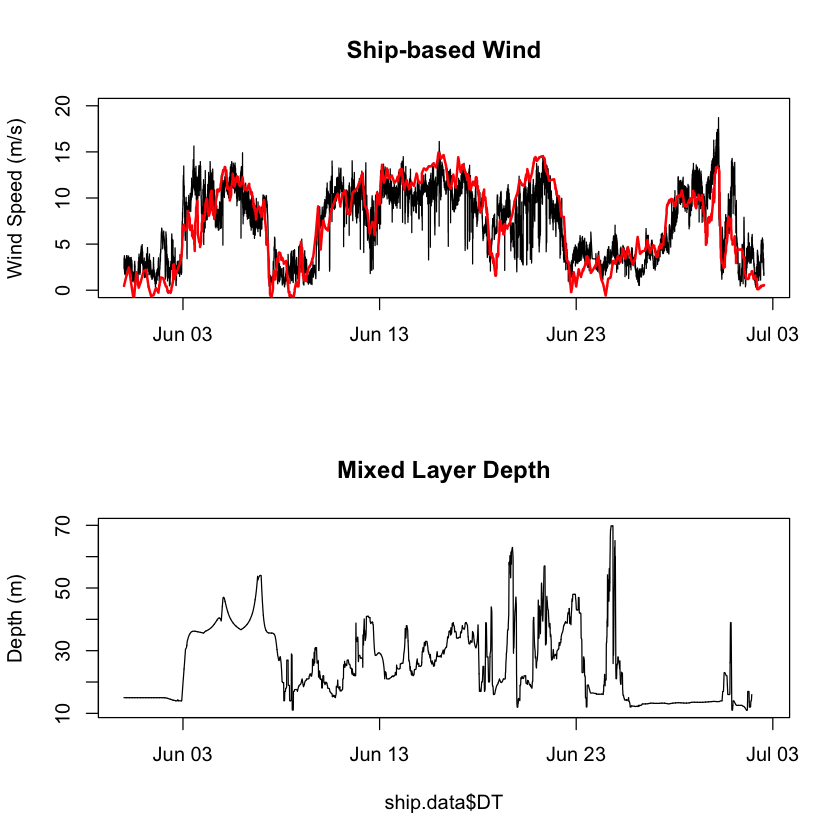

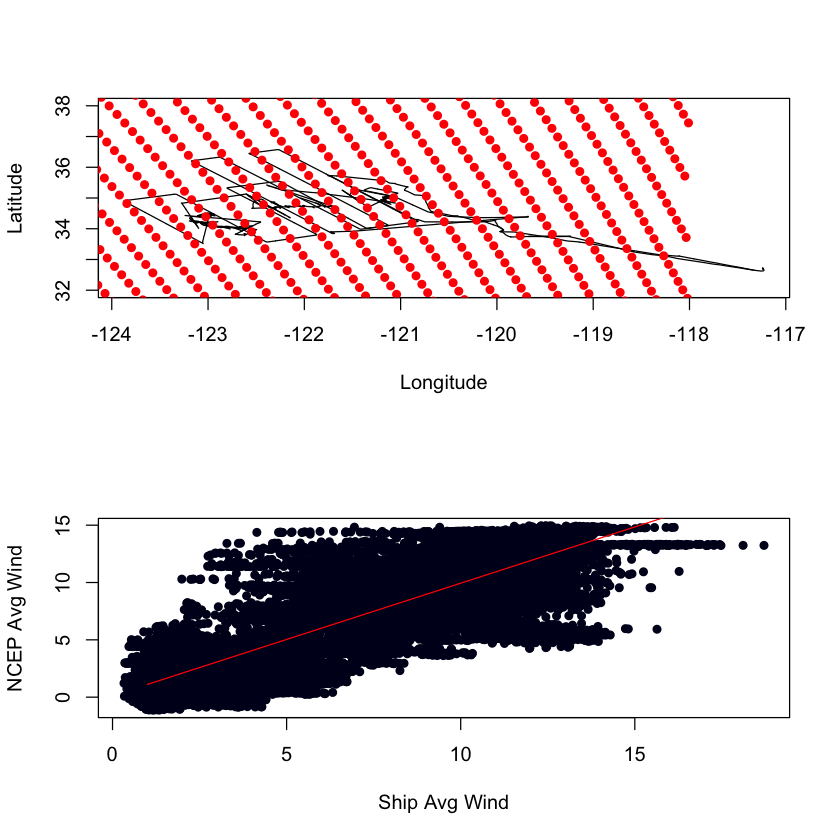

In [10]:
#pdf('./Output/Latest Wind.pdf')
par(mfrow=c(2,1))

################
## Plot Winds ##
################
plot(ship.data$DT, ship.data$TW, ylim=c(0,20), main='Ship-based Wind', xlab='', ylab='Wind Speed (m/s)', type='l')
lines(ship.data$DT, ship.data$NCEP, col='red', lwd=2)

##############
## MLD Plot ##
##############
plot(ship.data$DT, ship.data$MLD, type='l', ylab='Depth (m)', main='Mixed Layer Depth')


######################
### Plot of region ###
######################
## Plot showing the ship's track along with the grid points in the NCEP/NCAR data set

plot(ship.data$LO, ship.data$LA, type='l', ylim=c(32,38), xlab='Longitude', ylab='Latitude')

## Add grid points
for (i in 1:length(wind$lat)) {
    points(wind$lon[i], wind$lat[i], col='red', pch=16)
}


############################
### Plot with regression ###
############################
plot(ship.data$TW, ship.data$NCEP, col='#000020', pch=16, xlab='Ship Avg Wind', ylab='NCEP Avg Wind')
model = lm(NCEP ~ TW, data = ship.data)

lines(c(1:100), predict(model, newdata = data.frame(TW = c(1:100))), col='red')
#dev.off()

In [11]:
## TODO: do this correction before calculating k !!!! 
model = lm(NCEP ~ TW, data = ship.data)
coefficients(model)

#ship.data$NCEP = (ship.data$NCEP - coefficients(model)[[1]]) / coefficients(model)[[2]]

(Intercept)          TW 
  0.1286352   0.9811110

---

# 6. O2 Argon Data (EIMS)
This section will load the EIMS data and merge the useful columns with ship.data. The merge is done with linear interpolations baed on time.

Additionally, a new FLAG column will be added in order to monitor the sources & assumptions of the data going into the NCP calculations.

In [12]:
load('./RStates/EIMS.2min.2min.rdata')

(Intercept) eims$sample$O2.Sat.... 
             9.4904250              0.1458673

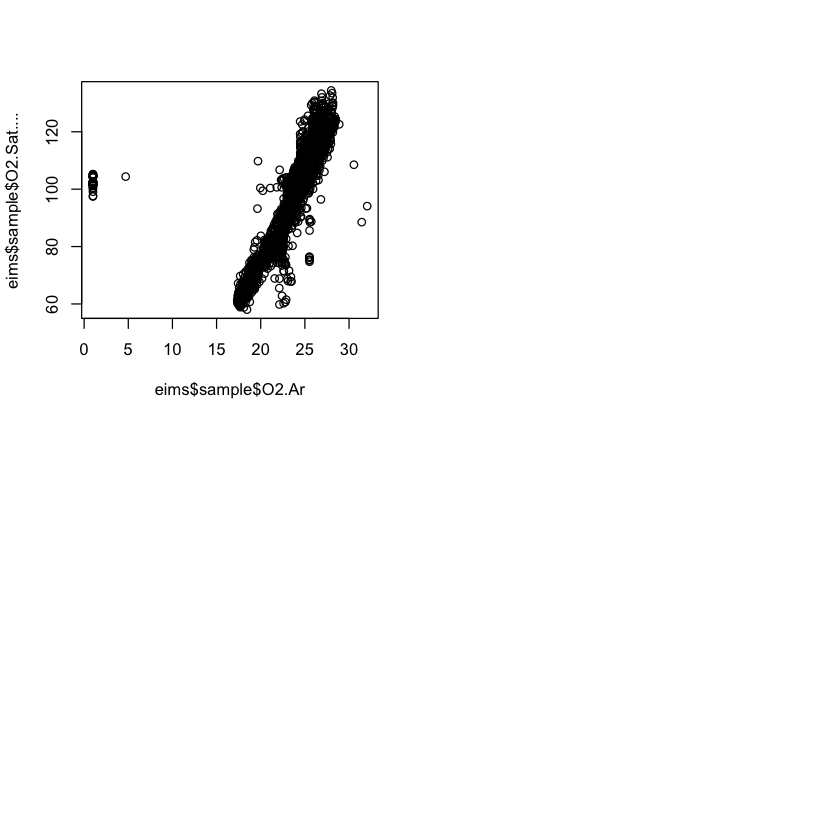

In [13]:
par(mfrow=c(2,2))
plot(eims$sample$O2.Ar, eims$sample$O2.Sat....)
mod = lm(eims$sample$O2.Ar ~ eims$sample$O2.Sat....)
coefficients(mod)

## 6a. Interpolate EIMS Data

This script deals with each variable separately (will be rolled into a function at some point).

1. O2:Ar measurements
 * Determine if during a gab in data (e.g. calibration, missing values, etc)
 * If not, then use closest value. FLAG = 1
 * If so, then check if for times are before and after.
  + Both sides: linear interp. FLAG = 2
  + One side, use that value (constant). FLAG = 3

2. O2:Ar Calibration
 * Determine if during a gab in data (e.g. non-calibration, missing values, etc)
 * If not, then use closest value. FLAG = 1
 * If so, then check if for times are before and after.
  + Both sides: linear interp. FLAG = 2
  + One side, use that value (constant). FLAG = 3

In [14]:
ship.data$O2.Ar.cal.FLAG = NULL
ship.data$O2.Ar.cal = NULL
ship.data$FLAG = NULL
ship.data$Cycle = NULL

In [15]:
eims.interp = function(ship.time, eims.time, ship.var, eims.var, FLAG) {
    ## First let's add the O2:Ar measurments
    for (i in 1:length(ship.time)) {
    
        ## Collect all the data points in the EIMS data within 2 minutes
        dt = as.numeric(difftime(eims.time, ship.time[i], unit='mins'))
        l = which(dt^2 < 3^2) ## check within X minutes
    
        ## Make sure there are enough data points (i.e. not during a calibration period)
        if (length(l) > 2) { 
        
            ## During a high-requency sampling period just use the closest in time value
            l.near = which.min(dt^2)
            ship.var[i] = mean(eims.var[l.near])
            FLAG[i] = 1 # Normal
        } 
    
        ## During a break in the data
        else {  
            ## TODO: Use O2 relationship instead
            if (all(dt < 0, na.rm = TRUE)) { # all times are before (negative)
                l = which.min(-dt)
                ship.var[i] = eims.var[l]
                FLAG[i] = 3  # Interp (1 sided)
            }
            else if (all(dt > 0, na.rm = TRUE)) { # al ltimes are after (pos)
                l = which.min(dt)
                ship.var[i] = eims.var[l]
                FLAG[i] = 3  # Interp (1 sided)
            }
            else {
                dt.left = -dt[dt < 0] # before
                dt.right = dt[dt > 0] # after

                l1 = which.min(dt.left) # left/before
                l2 = which.min(dt.right) # rigth/after

                y1 = eims.var[dt < 0][l1]
                y2 = eims.var[dt > 0][l2]

                m = (y2 - y1) / (dt[dt>0][l2] - dt[dt<0][l1])
                ans = m * -dt[dt < 0][l1] + y1

                if (length(ans) != 1) {
                    ship.var[i] = 0
                    FLAG[i] = 99  # Error
                } else{
                    ship.var[i] = ans
                    FLAG[i] = 2  # Interp (2 sided)
                }
            }
        }
    }
    return(list(var = ship.var, FLAG = FLAG))
}

In [16]:
eims.interp.o2 = function(ship.time, eims.time, ship.var, eims.var, FLAG) {
    ## First let's add the O2:Ar measurments
    for (i in 1:length(ship.time)) {
    
        ## Collect all the data points in the EIMS data within 2 minutes
        dt = as.numeric(difftime(ship.time[i], eims.time, unit='mins'))
        l = which(dt^2 < 3^2) ## check within X minutes
    
        ## Make sure there are enough data points (i.e. not during a calibration period)
        if (length(l) > 2) { 
        
            ## During a high-requency sampling period just use the closest in time value
            l.near = which.min(dt^2)
            ship.var[i] = mean(eims.var[l.near])
            FLAG[i] = 1 # Normal
        } 
    
        ## During a break in the data
        else {  
            ## TODO: Use O2 relationship instead
            if (all(dt < 0, na.rm = TRUE)) {
                l = which.min(-dt)
                ship.var[i] = eims.var[l]
                FLAG[i] = 3  # Interp (1 sided)
            }
            else if (all(dt > 0, na.rm = TRUE)) {
                l = which.min(dt)
                ship.var[i] = eims.var[l]
                FLAG[i] = 3  # Interp (1 sided)
            }
            else {
                dt.left = -dt[dt < 0]
                dt.right = dt[dt > 0]

                #l1 = which.min(dt.left) # left
                #l2 = which.min(dt.right) # rigth
                
                l1 = which.min((dt.left)) # left
                l2 = which.min(dt.right)  # rigth

                y1 = mean(eims.var[dt < 0][l1]) # O2 argon signal
                y2 = mean(eims.var[dt > 0][l2]) # O2 argon signal
                
                ## get O2 concentration
                #x1 = which.min(as.numeric(difftime(eims.time[dt < 0][l1], ship.data$DT, unit='mins'))^2)
                #x2 = which.min(as.numeric(difftime(eims.time[dt > 0][l2], ship.data$DT, unit='mins'))^2)
                
                #x1 = which(order(as.numeric(difftime(eims.time[dt < 0][l1[1]], ship.data$DT, unit='mins'))^2) < 5)
                #x2 = which(order(as.numeric(difftime(eims.time[dt > 0][l2[1]], ship.data$DT, unit='mins'))^2) < 5)
                
                #oxy.1 = mean(ship.data$OS[x1])
                #oxy.2 = mean(ship.data$OS[x2])

                #m.oxy = (y2 - y1) / (oxy.2 - oxy.1)
                m.t = (y2 - y1) / (dt[dt>0][l2] - dt[dt<0][l1])
                m = m.t
                
                ans = m * ship.data$OS[i] + y1

                if (length(ans) != 1) {
                    ship.var[i] = 0
                    FLAG[i] = 99  # Error
                } else{
                    ship.var[i] = ans
                    FLAG[i] = 2  # Interp (2 sided)
                }
            }
        }
    }
    return(list(var = ship.var, FLAG = FLAG))
}

In [17]:
ze = rep(0, nrow(ship.data))

## O2 Argon from EIMS
temp = eims.interp(ship.data$DT, eims$sample$time, ze, eims$sample$O2.Ar, ze)
ship.data$O2.Ar = temp[[1]]
ship.data$FLAG.O2.Ar = temp[[2]]

# Inlet Temperature
#temp = eims.interp(ship.data$DT, rbind(eims.v1$time, eims.v2$time), ze, rbind(eims.v1$inlet, eims.v2$inlet), ze)
temp = eims.interp(ship.data$DT, eims$sample$time, ze, eims$sample$inlet, ze)
ship.data$Inlet.T = temp[[1]]
ship.data$FLAG.Inlet.T = temp[[2]]

# Oxygen EIMS 32
temp = eims.interp(ship.data$DT, eims$sample$time, ze, eims$sample$X32, ze)
ship.data$EIMS.32 = temp[[1]]
ship.data$FLAG.EIMS.32 = temp[[2]]

# Oxygen Conc
temp = eims.interp(ship.data$DT, eims$sample$time, ze, eims$sample$O2..uM., ze)
ship.data$EIMS.O2 = temp[[1]]
ship.data$FLAG.EIMS.O2 = temp[[2]]

# Oxygen Sat
temp = eims.interp(ship.data$DT, eims$sample$time, ze, eims$sample$O2.Sat...., ze)
ship.data$EIMS.O2.sat = temp[[1]]
ship.data$FLAG.EIMS.O2.sat = temp[[2]]


## Calibration
temp = eims.interp(ship.data$DT, eims$cal$time, ze, eims$cal$O2.Ar, ze)
ship.data$O2.Ar.cal = temp[[1]]
ship.data$FLAG.O2.Ar.cal = temp[[2]]

# Inlet Temperature
#temp = eims.interp(ship.data$DT, rbind(eims.v1$time, eims.v2$time), ze, rbind(eims.v1$inlet, eims.v2$inlet), ze)
temp = eims.interp(ship.data$DT, eims$cal$time, ze, eims$cal$inlet, ze)
ship.data$Inlet.T.cal = temp[[1]]
ship.data$FLAG.Inlet.T.cal = temp[[2]]

# Oxygen EIMS 32
temp = eims.interp(ship.data$DT, eims$cal$time, ze, eims$cal$X32, ze)
ship.data$EIMS.32.cal = temp[[1]]
ship.data$FLAG.EIMS.32.cal = temp[[2]]

# Oxygen Conc
temp = eims.interp(ship.data$DT, eims$cal$time, ze, eims$cal$O2..uM., ze)
ship.data$EIMS.O2.cal = temp[[1]]
ship.data$FLAG.EIMS.O2.cal = temp[[2]]

# Oxygen Sat
temp = eims.interp(ship.data$DT, eims$cal$time, ze, eims$cal$O2.Sat...., ze)
ship.data$EIMS.O2.sat.cal = temp[[1]]
ship.data$FLAG.EIMS.O2.sat.cal = temp[[2]]

## 6b. Check EIMS Data

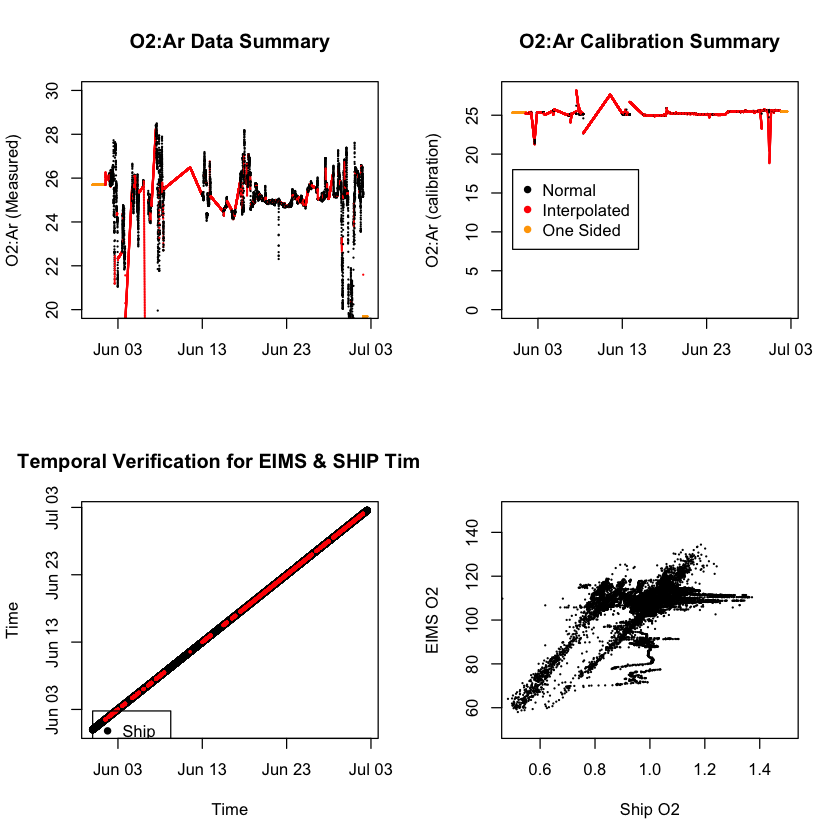

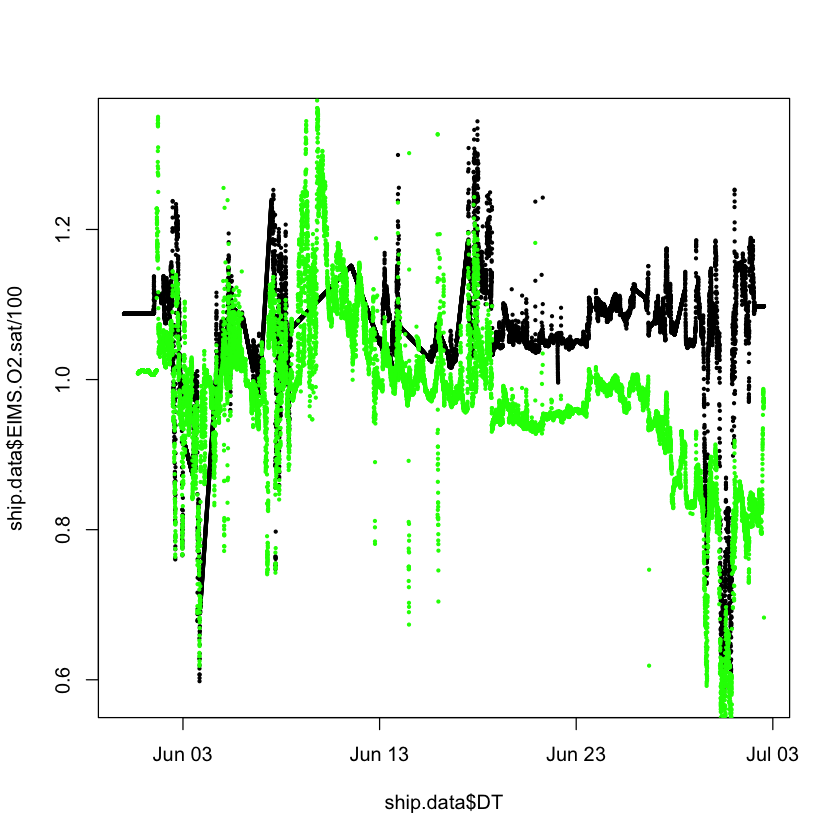

In [18]:
par(mfrow=c(2,2))
#pdf('Output/EIMS_Data Summary.pdf')

flag.color = c('black', 'red', 'orange', 'orange')

## O2 argon verification
plot(ship.data$DT, ship.data$O2.Ar, col=flag.color[ship.data$FLAG.O2.Ar], ylim=c(20,30),
     pch=16, cex=0.3, ylab='O2:Ar (Measured)', xlab='', main='O2:Ar Data Summary')
legend(ship.data$DT[1], 18, col=flag.color, c('Normal', 'Interpolated', 'One Sided'), pch=16, cex=0.55)

## Calibration verification
plot(ship.data$DT, ship.data$O2.Ar.cal, col=flag.color[ship.data$FLAG.O2.Ar.cal],
     pch=16, cex=0.3, ylab='O2:Ar (calibration)', xlab='', main='O2:Ar Calibration Summary')
legend(ship.data$DT[1], 18, col=flag.color, c('Normal', 'Interpolated', 'One Sided'), pch=16)

## Time validation
plot(ship.data$DT, ship.data$DT, pch=16, cex=1, ylab='Time', xlab='Time', main='Temporal Verification for EIMS & SHIP Times')
points(eims$sample$time, eims$sample$time, col='red', pch=16, cex=0.5)
legend(ship.data$DT[1], ship.data$DT[2000], c('Ship', 'EIMS'), col=c('black', 'red'), pch=16)

## Oxygen Comparison
plot(ship.data$OX / ship.data$OS, ship.data$EIMS.O2.sat, pch=20, cex=0.2, ylim=c(50,150), xlim=c(0.5,1.5),
     xlab='Ship O2', ylab='EIMS O2')

par(mfrow=c(1,1))
plot(ship.data$DT, ship.data$EIMS.O2.sat/100, pch=20, cex=0.5)
points(ship.data$DT, ship.data$OX / ship.data$OS, pch=20, cex=0.5, col='green')


#a = ccf(x = ship.data$EIMS.O2.sat[3000:(nrow(ship.data))]/100, y = ship.data$OX[1:(nrow(ship.data)-2999)] / ship.data$OS[1:(nrow(ship.data)-2999)], lag.max = 5000)
#dev.off()

# MIMS Data

In [19]:
load('RStates/MIMS.rdata')

In [20]:
ze = rep(0, nrow(ship.data))

## O2 Argon from MIMS
temp = eims.interp(ship.data$DT, mims$sample$time, ze, mims$sample$O2.Ar, ze)
ship.data$MIMS.O2.Ar = temp[[1]]
ship.data$MIMS.FLAG.O2.Ar = temp[[2]]


# Oxygen MIMS 32
temp = eims.interp(ship.data$DT, mims$sample$time, ze, mims$sample$X32, ze)
ship.data$MIMS.32 = temp[[1]]
ship.data$MIMS.FLAG.32 = temp[[2]]

# N2/Ar
temp = eims.interp(ship.data$DT, mims$sample$time, ze, mims$sample$N2.Ar, ze)
ship.data$MIMS.N2Ar = temp[[1]]
ship.data$MIMS.FLAG.N2Ar = temp[[2]]

# MIMS 44
temp = eims.interp(ship.data$DT, mims$sample$time, ze, mims$sample$X44, ze)
ship.data$MIMS.CO2 = temp[[1]]
ship.data$MIMS.FLAG.CO2 = temp[[2]]

###########################################################################
## Calibration MIMS
temp = eims.interp(ship.data$DT, mims$cal$time, ze, mims$cal$O2.Ar, ze)
ship.data$MIMS.O2.Ar.cal = temp[[1]]
ship.data$MIMS.FLAG.O2.Ar.cal = temp[[2]]

# Oxygen MIMS 32
temp = eims.interp(ship.data$DT, mims$cal$time, ze, mims$cal$X32, ze)
ship.data$MIMS.32.cal = temp[[1]]
ship.data$MIMS.FLAG.32.cal = temp[[2]]

# N2/Ar
temp = eims.interp(ship.data$DT, mims$cal$time, ze, mims$cal$N2.Ar, ze)
ship.data$MIMS.N2Ar.cal = temp[[1]]
ship.data$MIMS.FLAG.N2Ar.cal = temp[[2]]

# MIMS 44
temp = eims.interp(ship.data$DT, mims$cal$time, ze, mims$cal$X44, ze)
ship.data$MIMS.CO2 = temp[[1]]
ship.data$MIMS.FLAG.CO2 = temp[[2]]

## 7b. Check MIMS data

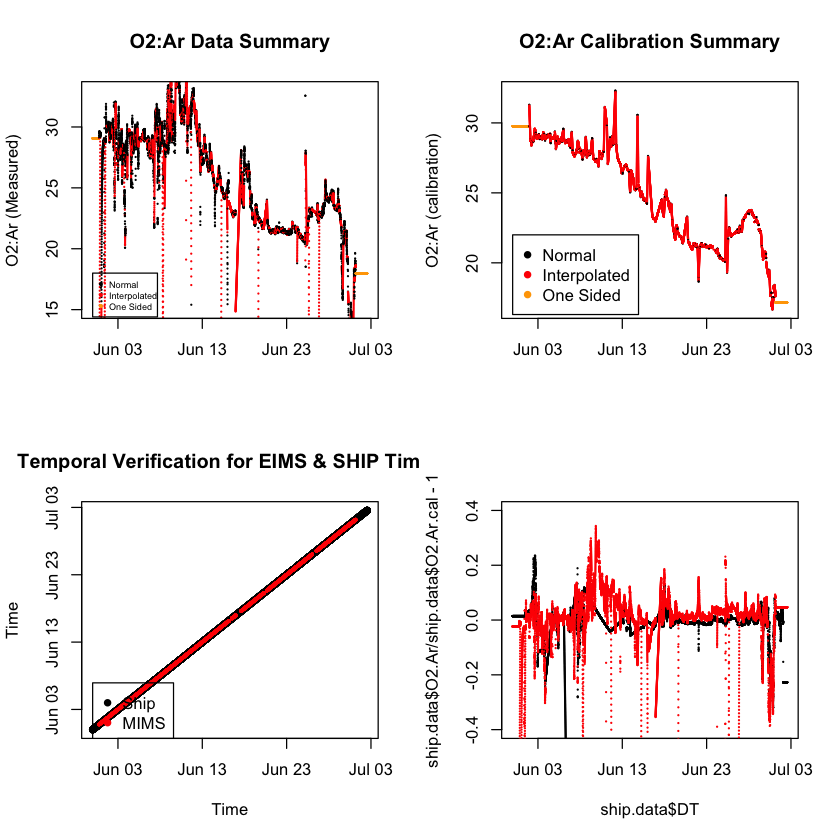

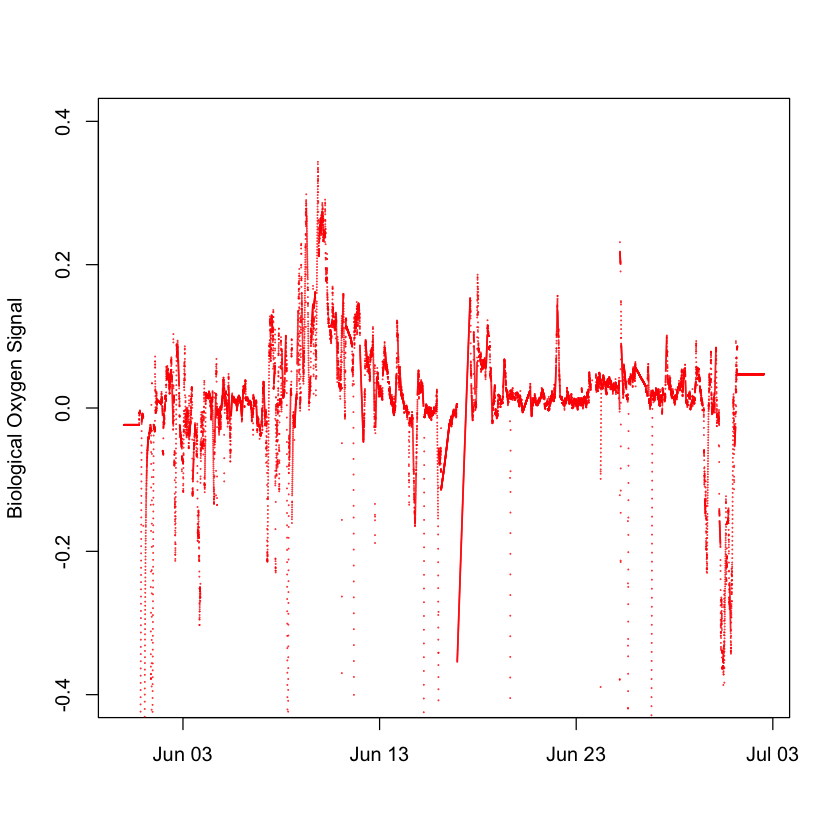

In [21]:
par(mfrow=c(2,2))
#pdf('Output/EIMS_Data Summary.pdf')

flag.color = c('black', 'red', 'orange', 'orange')

## O2 argon verification
plot(ship.data$DT, ship.data$MIMS.O2.Ar, col=flag.color[ship.data$MIMS.FLAG.O2.Ar], ylim=c(15,33),
     pch=16, cex=0.3, ylab='O2:Ar (Measured)', xlab='', main='O2:Ar Data Summary')
legend(ship.data$DT[1], 18, col=flag.color, c('Normal', 'Interpolated', 'One Sided'), pch=16, cex=0.55)

## Calibration verification
plot(ship.data$DT, ship.data$MIMS.O2.Ar.cal, col=flag.color[ship.data$MIMS.FLAG.O2.Ar.cal],
     pch=16, cex=0.3, ylab='O2:Ar (calibration)', xlab='', main='O2:Ar Calibration Summary')
legend(ship.data$DT[1], 22, col=flag.color, c('Normal', 'Interpolated', 'One Sided'), pch=16)

## Time validation
plot(ship.data$DT, ship.data$DT, pch=16, cex=1, ylab='Time', xlab='Time', main='Temporal Verification for EIMS & SHIP Times')
points(mims$sample$time, mims$sample$time, col='red', pch=16, cex=0.5)
legend(ship.data$DT[1], ship.data$DT[5000], c('Ship', 'MIMS'), col=c('black', 'red'), pch=16)

## Oxygen Comparison
plot(ship.data$DT, ship.data$O2.Ar / ship.data$O2.Ar.cal - 1, pch=20, cex=0.2, ylim=c(-0.4, 0.4))
points(ship.data$DT, ship.data$MIMS.O2.Ar / ship.data$MIMS.O2.Ar.cal - 1,
       pch=20, cex=0.2, col='red')

par(mfrow=c(1,1))
plot(ship.data$DT, ship.data$O2.Ar / ship.data$O2.Ar.cal - 1, pch=20, cex=0.2, ylim=c(-0.4, 0.4),
     ylab='Biological Oxygen Signal', xlab='', col='white')
points(ship.data$DT, ship.data$MIMS.O2.Ar / ship.data$MIMS.O2.Ar.cal - 1,
       pch=20, cex=0.1, col='red')

#a = ccf(x = ship.data$EIMS.O2.sat[3000:(nrow(ship.data))]/100, y = ship.data$OX[1:(nrow(ship.data)-2999)] / ship.data$OS[1:(nrow(ship.data)-2999)], lag.max = 5000)
#dev.off()

## 8c. Optode Data

In [22]:
load('RStates/Optode 12.04.17.rdata')

In [23]:
## Oxygen ch 1
temp = eims.interp(ship.data$DT, optode$Starttime, ze, optode$Oxy1, ze)
ship.data$Optode.ch1 = temp[[1]]
ship.data$Optode.ch1.FLAG = temp[[2]]

## Oxygen ch 2
temp = eims.interp(ship.data$DT, optode$Starttime, ze, optode$Oxy2, ze)
ship.data$Optode.ch2 = temp[[1]]
ship.data$Optode.ch2.FLAG = temp[[2]]

## Oxygen ch 3
temp = eims.interp(ship.data$DT, optode$Starttime, ze, optode$Oxy3, ze)
ship.data$Optode.ch3 = temp[[1]]
ship.data$Optode.ch3.FLAG = temp[[2]]

## Oxygen ch 4
temp = eims.interp(ship.data$DT, optode$Starttime, ze, optode$Oxy4, ze)
ship.data$Optode.ch4 = temp[[1]]
ship.data$Optode.ch4.FLAG = temp[[2]]

## Oxygen T 1
temp = eims.interp(ship.data$DT, optode$Starttime, ze, optode$T1, ze)
ship.data$Optode.temp1 = temp[[1]]
ship.data$Optode.temp1.FLAG = temp[[2]]

## Oxygen T 2
temp = eims.interp(ship.data$DT, optode$Starttime, ze, optode$T2, ze)
ship.data$Optode.temp2 = temp[[1]]
ship.data$Optode.temp2.FLAG = temp[[2]]

## Oxygen T 3
temp = eims.interp(ship.data$DT, optode$Starttime, ze, optode$T3, ze)
ship.data$Optode.temp3 = temp[[1]]
ship.data$Optode.temp3.FLAG = temp[[2]]

## Oxygen T 4
temp = eims.interp(ship.data$DT, optode$Starttime, ze, optode$T4, ze)
ship.data$Optode.temp4 = temp[[1]]
ship.data$Optode.temp4.FLAG = temp[[2]]

## Optode Pressure
temp = eims.interp(ship.data$DT, optode$Starttime, ze, optode$Pressure, ze)
ship.data$Optode.pressure = temp[[1]]
ship.data$Optode.pressure.FLAG = temp[[2]]

In [24]:
## Filter by moving average


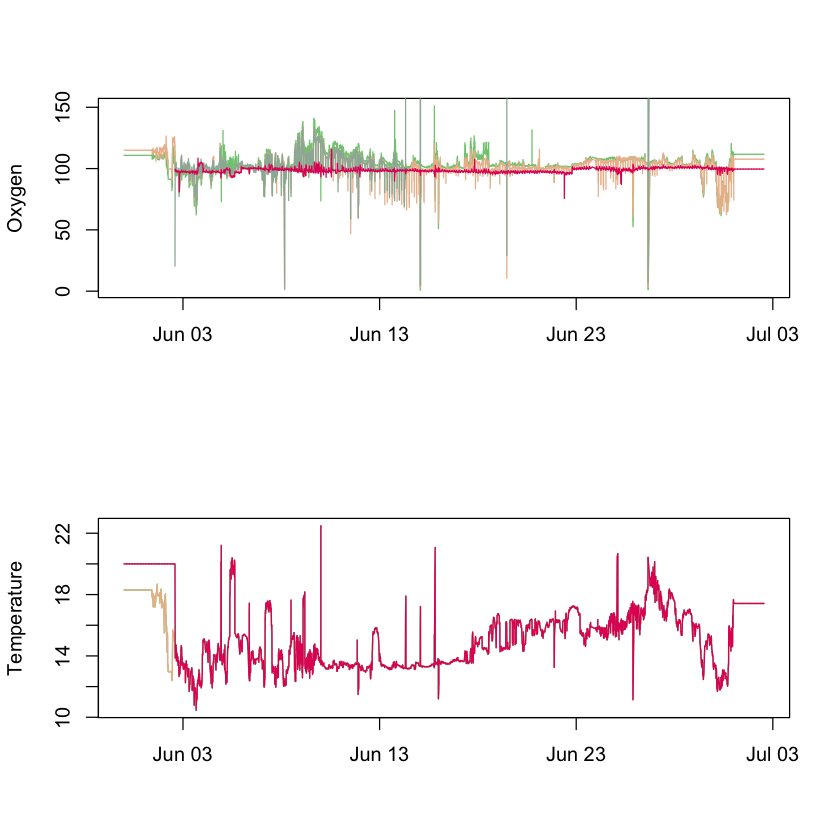

In [25]:
par(mfrow=c(2,1))
cols = get.qual.pal(5)

plot(ship.data$DT, ship.data$Optode.ch1, type='l', col = cols[1], xlab = '', ylab = 'Oxygen')
lines(ship.data$DT, ship.data$Optode.ch2, col = cols[2])
lines(ship.data$DT, ship.data$Optode.ch3, col = cols[3])
lines(ship.data$DT, ship.data$Optode.ch4, col = cols[4])

plot(ship.data$DT, ship.data$Optode.temp1, type='l', col = cols[1], xlab = '', ylab = 'Temperature')
lines(ship.data$DT, ship.data$Optode.temp2, col = cols[2])
lines(ship.data$DT, ship.data$Optode.temp3, col = cols[3])
lines(ship.data$DT, ship.data$Optode.temp4, col = cols[4])

In [26]:
l = which(abs(ship.data$Optode.ch1 - ma(ship.data$Optode.ch1, n = 10)) > sd(ship.data$Optode.ch1))
length(l) / nrow(ship.data)

[1] 0.003571736

## Ensure alignment

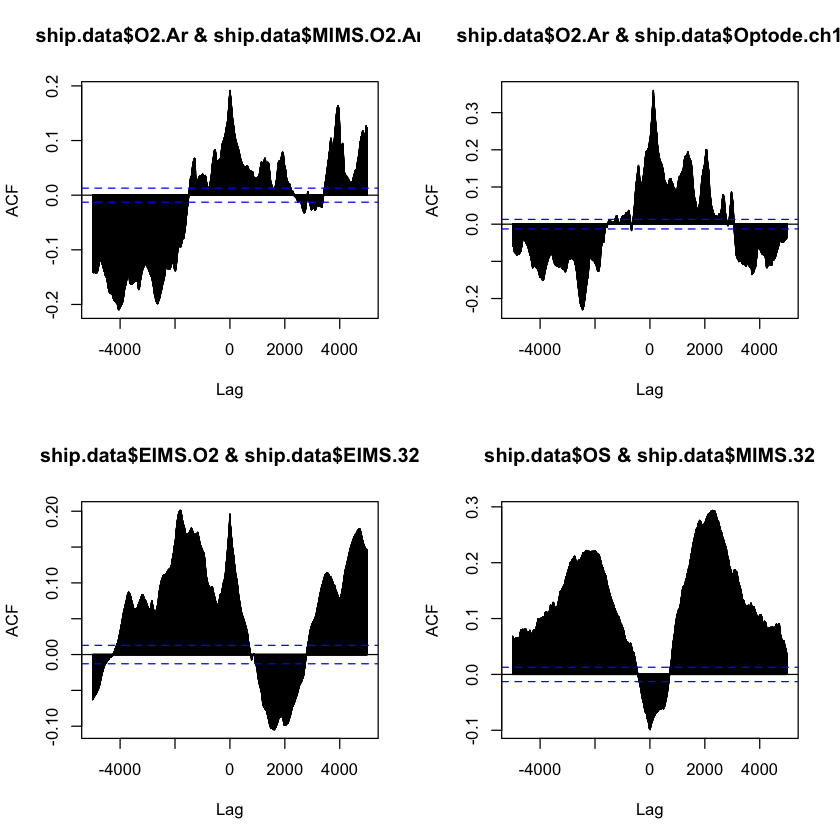

In [27]:
par(mfrow=c(2,2))

ccf(ship.data$O2.Ar, ship.data$MIMS.O2.Ar, lag.max = 5000)
ccf(ship.data$O2.Ar, ship.data$Optode.ch1, lag.max = 5000)
ccf(ship.data$EIMS.O2, ship.data$EIMS.32, lag.max = 5000)
ccf(ship.data$OS, ship.data$MIMS.32, lag.max = 5000)

---
# 7. Cycle Information

This section simply fined the nearest timestamp in the ship's log and adds the "Cycle" entry to the ship.data.

In [28]:
cycles = read.xlsx('Raw Data/CCEP1706 Event Log.xlsx')
cycles$Datetime.UTC = conv_excel_time(cycles$Datetime.UTC, tz='UTC')

ship.data$Cycle = NULL

for (i in 1:nrow(ship.data)) {
    dt = abs(as.numeric(difftime(ship.data$DT[i], cycles$Datetime.UTC, unit='mins')))
    ship.data$Cycle[i] = cycles$Cycle[which.min(dt)]
}

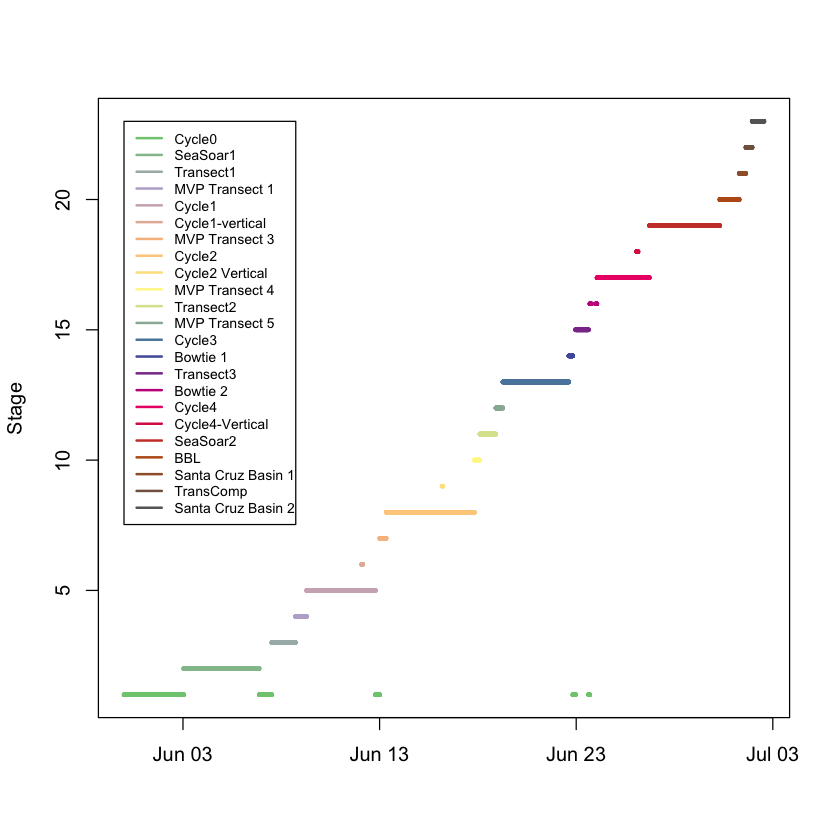

In [29]:
#pdf('Output/Sequence ofEvents.pdf')

l = unique(ship.data$Cycle)
cols = sapply(ship.data$Cycle, function(x) {which(l == x)} )

plot(ship.data$DT, cols, col=get.qual.pal(length(l))[cols], pch=16, cex=0.5, ylab='Stage', xlab='')
legend(ship.data$DT[1], length(l), l, col=get.qual.pal(length(l)), lwd=2, cex=0.7)

#dev.off()

'data.frame':	1697 obs. of  13 variables:
 $ Cycle       : num  1 1 1 1 1 1 1 1 1 1 ...
 $ Device      : chr  "OHM-MS-0001" "OHM-MS-0001" "OHM-MS-0001" "OHM-MS-0001" ...
 $ Array       : chr  "DriftArray" "DriftArray" "DriftArray" "DriftArray" ...
 $ DeviceTime  : num  42896 42896 42896 42896 42896 ...
 $ X5          : num  42896 42896 42896 42896 42896 ...
 $ X6          : num  43236 43808 44408 45008 45608 ...
 $ X7          : num  3 3 3 3 3 3 3 3 3 3 ...
 $ Lat         : num  35.1 35.1 35.1 35.1 35.1 ...
 $ Lon         : num  -121 -121 -121 -121 -121 ...
 $ Temp        : num  NA NA NA NA NA NA NA NA NA NA ...
 $ Batt.Voltage: num  11.5 11.5 11.5 11.5 11.5 11.5 11.5 11.5 11.5 11.5 ...
 $ Submerged   : num  1 1 1 1 1 1 1 1 1 1 ...
 $ time        : POSIXct, format: "2017-06-09 08:00:36" "2017-06-09 08:10:08" ...


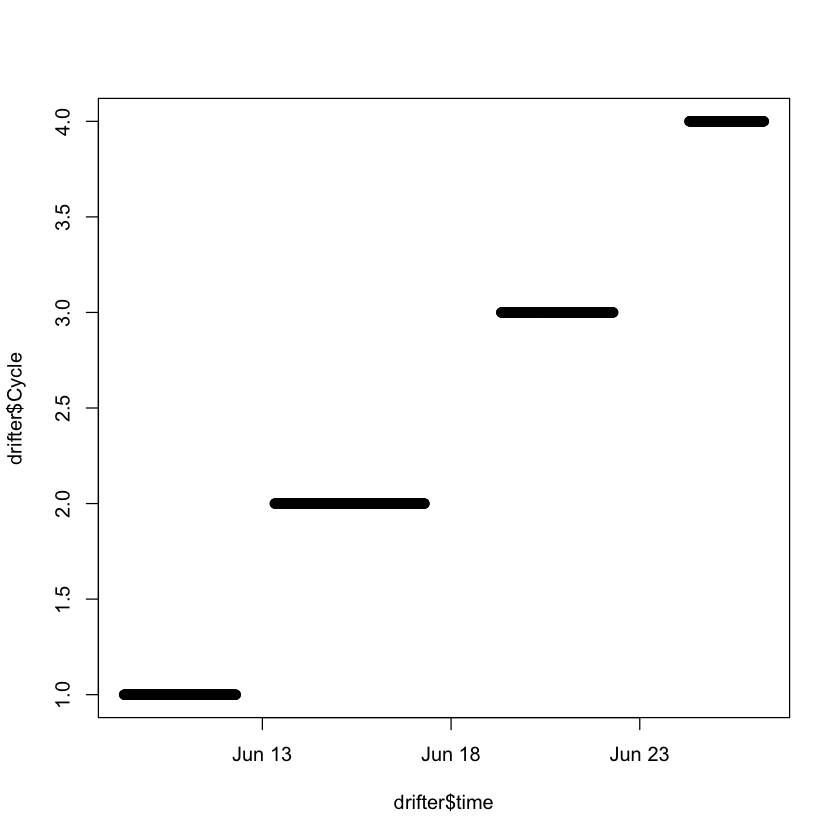

In [30]:
drifter = read.xlsx('Raw Data/CCEP1706 - DrifterTracks.xlsx')
drifter$time = conv_excel_time(drifter$DeviceTime, tz = 'PDT')
drifter = drifter[which(drifter$Array == 'DriftArray'),] ## Only want drifter array locations
str(drifter)
plot(drifter$time, drifter$Cycle)

In [31]:
add.drifter = function(data, drifter) {
    
    data$Drifter.lat = 0
    data$Drifter.lon = 0

    for (i in 1:nrow(data)) {
        dt = as.numeric(difftime(drifter$time, data$DT[i], units='hours')) ## hours
        l = which(abs(dt) < 1)

        ## No (or just 1) drifter times within 1 hr, skip
        if (length(l) > 1) {
            dt.pos = dt[dt > 0]
            dt.neg = dt[dt < 0]

            if (length(dt.neg) < 1) { # all close times are afterwards

                data$Drifter.lat[i] = drifter$Lat[which.min(dt)]
                data$Drifter.lon[i] = drifter$Lon[which.min(dt)]
            }
            else if (length(dt.pos) < 1) { # all close times are before
                data$Drifter.lat[i] = drifter$Lat[which.min(-dt)]
                data$Drifter.lon[i] = drifter$Lon[which.min(-dt)]
            }
            else { ## Interpolate
                t1 = which.min(dt[dt > 0])
                t2 = which.min(-dt[dt < 0])

                lats = c(drifter$Lat[which(dt < 0)[t2]], drifter$Lat[which(dt > 0)[t1]])
                lons = c(drifter$Lon[which(dt < 0)[t2]], drifter$Lon[which(dt > 0)[t1]])
                times = c(-dt[dt < 0][t2], dt[dt > 0][t1])

                data$Drifter.lat[i] = lats[1] * (1 - times[1]/sum(times)) + lats[2] * (1-times[2]/sum(times))
                data$Drifter.lon[i] = lons[1] * (1 - times[1]/sum(times)) + lons[2] * (1-times[2]/sum(times))
            }
        }
    }
    data
}

In [32]:
ship.data = add.drifter(ship.data, drifter)

## Spatial Plots

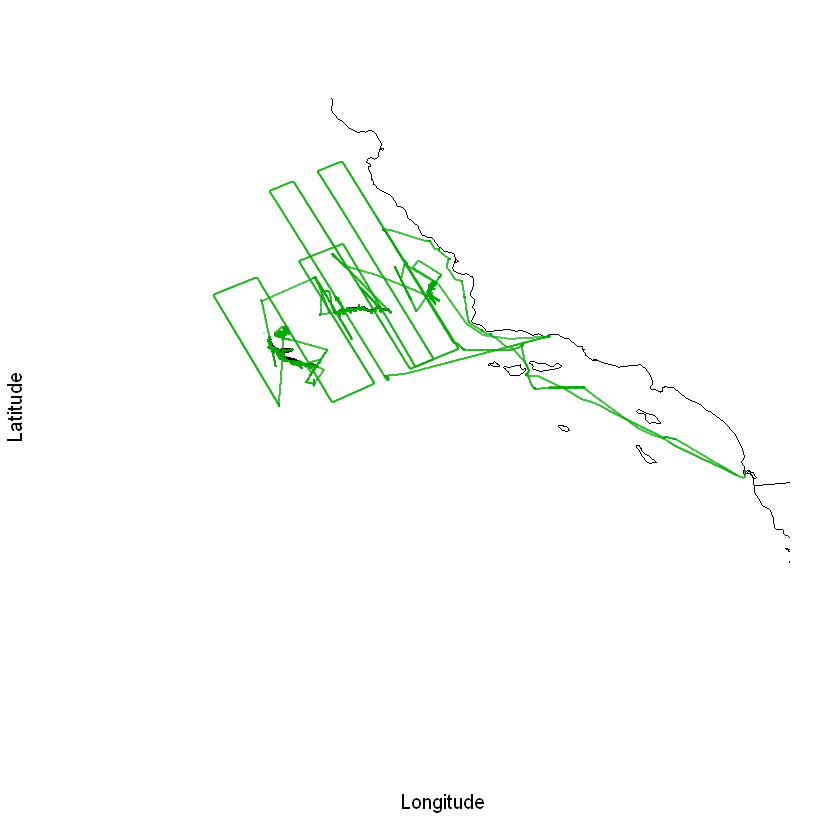

In [7]:
newmap <- getMap(resolution = "high")
plot(newmap, xlim = c(-125, -117), ylim = c(31, 36), asp = 1, ylab='Latitude', xlab='Longitude')

points(ship.data$Drifter.lon, ship.data$Drifter.lat, pch=16, cex=0.3)
points(ship.data$LO, ship.data$LA, pch=16, cex=0.2, col='#00aa0050')

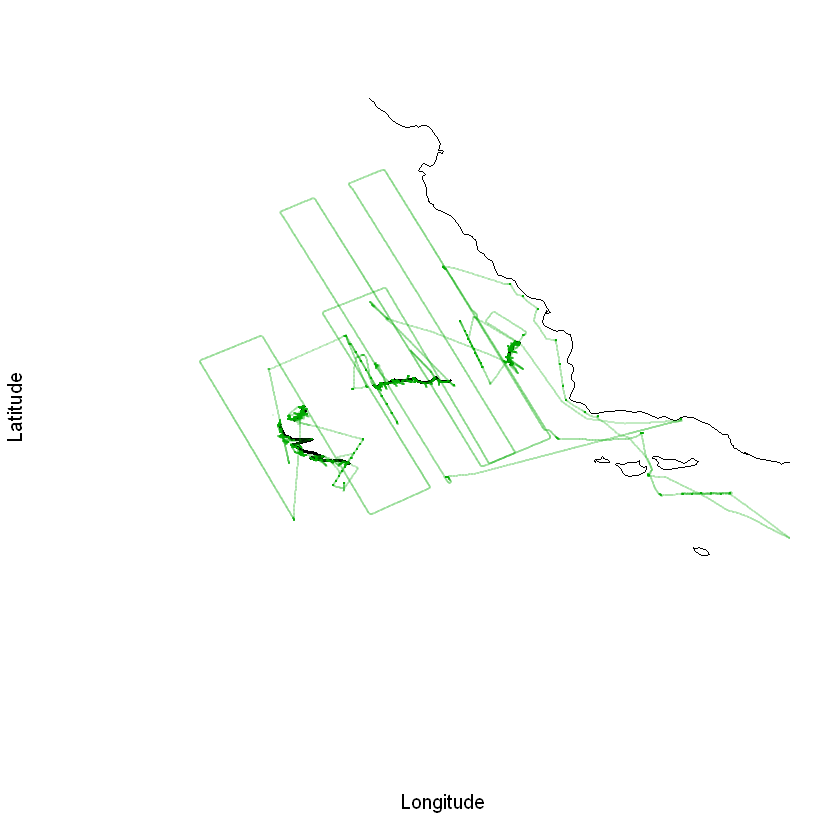

In [12]:
newmap <- getMap(resolution = "high")
plot(newmap, xlim = c(-124, -119.5), ylim = c(32, 37), asp = 1, ylab='Latitude', xlab='Longitude')

points(ship.data$Drifter.lon, ship.data$Drifter.lat, pch=16, cex=0.3)
points(ship.data$LO, ship.data$LA, pch=16, cex=0.1, col='#00aa0020')

## Save

In [34]:
save(ship.data, file='./RStates/ship.final.rdata')
write.xlsx(ship.data, file='./Input Data/Shipdata - Final.xlsx')

Note: no visible binding for global variable '.->sheet_names' 
Note: no visible binding for global variable '.->isChartSheet' 
Note: no visible binding for global variable '.->Content_Types' 
Note: no visible binding for global variable '.->core' 
Note: no visible binding for global variable '.->sheetOrder' 
Note: no visible binding for '<<-' assignment to 'charts' 
Note: no visible binding for '<<-' assignment to 'isChartSheet' 
Note: no visible binding for '<<-' assignment to 'colWidths' 
Note: no visible binding for '<<-' assignment to 'connections' 
Note: no visible binding for '<<-' assignment to 'Content_Types' 
Note: no visible binding for '<<-' assignment to 'core' 
Note: no visible binding for '<<-' assignment to 'comments' 
Note: no visible binding for '<<-' assignment to 'drawings' 
Note: no visible binding for '<<-' assignment to 'drawings_rels' 
Note: no visible binding for '<<-' assignment to 'embeddings' 
Note: no visible binding for '<<-' assignment to 'externalLinks' 


In [2]:
load(file='./RStates/ship.final.rdata')